In [22]:
import requests as r
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [7]:
def getTradeInfo(html):
    try:
        cik = html.find('rptOwnerCik'.lower()).text
    except AttributeError:
        raise AttributeError('different doc type')
    name = html.find('rptOwnerName'.lower()).text
    dates, sales, amounts, rsus = [], [], [], []
    footnotes = html.find('footnotes')
    for transaction in html.findAll('nonDerivativeTransaction'.lower()):
        dates.append(pd.to_datetime( transaction.find('transactionDate'.lower()).text.strip() ))
        sales.append(transaction.find('transactionAcquiredDisposedCode'.lower()).text.strip() == 'D')
        
        shares = transaction.find('transactionShares'.lower())
        amounts.append(float( shares.text.strip() ))
        footnoteNm = shares.find('footnoteId'.lower()).attrs['id']
        footnoteTxt = footnotes.find(id=footnoteNm).text.lower()
        rsus.append(isRSUTrade(footnoteTxt))
    return cik, name, dates, sales, amounts, rsus

def isRSUTrade(text):
    rsuStrings = ['restricted', 'stock', 'units']
    return all(text.find(rsuString) > -1 for rsuString in rsuStrings)

def parsePathSuffixsFromCompanyFile(companyFile, companyName, formIndex=2, formName='4'):
    pathSuffixs = []
    foundCompany = False
    for line in companyFile:
        ls = line.split()
        if len(ls) > 3:
            if ls[:formIndex] == companyName.split() and ls[formIndex] == formName:
                pathSuffixs.append(ls[-1])
                foundCompany = True
            elif foundCompany is True:
                break #sorted by company
    return pathSuffixs

In [3]:
#parameters
currYear = 2020
fileNameZip, fileName = 'company.zip', 'company.idx'
companyName = 'BOEING CO'
formName = '4'
years = [i for i in range(1993, currYear+1)]
#years = [i for i in range(2018, 2021)] #test
quarters = ['QTR{}'.format(i+1) for i in range(4)]

In [9]:
#read local form 4's for company companyName as indexed
#by company.idx in year/quarter/ local files into memory
#build as
#dict(([dates], [sales], [amounts], [ownedAfters]))[cik]
#later transform to
#dict(pd.dataframe[date, sale, amount, ownedAfter])[cik]
transactions = dict()
cikToName = dict()
cikToPaths = dict()
knownDocType, differentDocType = 0, 0
for year in years:
    for quarter in quarters:
        path = '/'.join(('./data', str(year), quarter, ''))
        try:
            with open(path + fileName, 'r') as f:
                pathSuffixs = parsePathSuffixsFromCompanyFile(f, companyName, formName=formName)
        except FileNotFoundError:
            print('no file {} found'.format(path + fileName))
        else:
            #read from files into memory
            for pathSuffix in pathSuffixs:
                #pathSuffix form: 'edgar/data/.../....txt'
                path = '/'.join(('.', pathSuffix[6:]))
                with open(path, 'r') as f:
                    fileText = ''.join(line for line in f)
                html = BeautifulSoup(fileText, 'html.parser')
                try:
                    cik, name, dates, sales, amounts, rsus = getTradeInfo(html)
                except AttributeError:
                    differentDocType += 1
                else:
                    knownDocType += 1
                    if len(dates) > 0:
                        if cik not in transactions:
                            cikToName[cik] = name
                            cikToPaths[cik] = []
                            transactions[cik] = {'dates': [],
                                                 'sales': [],
                                                 'amounts': [],
                                                 'rsus': []}
                        cikToPaths[cik].append(path)
                        transactions[cik]['dates'] += dates
                        transactions[cik]['sales'] += sales
                        transactions[cik]['amounts'] += amounts
                        transactions[cik]['rsus'] += rsus
totalDocs = knownDocType + differentDocType
print('main loop done. knownDocType, differentDocType, frac known, frac diff: '
      f'{knownDocType}, {differentDocType}, {knownDocType/totalDocs}, {differentDocType/totalDocs}')

no file ./data/2020/QTR3/company.idx found
no file ./data/2020/QTR4/company.idx found
main loop done. knownDocType, differentDocType, frac known, frac diff: 1497, 744, 0.6680053547523427, 0.3319946452476573


In [11]:
print(len(transactions),
    sum(len(transactions[key]) for key in transactions))
#transactions

39 156


In [12]:
#convert to dataframes & change amounts to account for transaction direction
for cik in transactions:
    transactions[cik] = pd.DataFrame(transactions[cik])
    transactions[cik]['amounts'] = transactions[cik]['amounts'] * (1. - 2. * transactions[cik]['sales'])

In [15]:
someCik = '0001671300'
print(cikToPaths[someCik])
transactions[someCik]

['./data/12927/0001225208-17-005016.txt', './data/12927/0001225208-17-005138.txt', './data/12927/0001225208-17-005812.txt', './data/12927/0001225208-18-004468.txt', './data/12927/0001225208-18-004780.txt', './data/12927/0001225208-18-005450.txt', './data/12927/0001225208-19-003803.txt', './data/12927/0001225208-19-003870.txt', './data/12927/0001225208-19-004665.txt', './data/12927/0001225208-20-003508.txt', './data/12927/0001225208-20-003596.txt', './data/12927/0001225208-20-003946.txt', './data/12927/0001225208-20-004789.txt']


,dates,sales,amounts,rsus
0,2017-02-24,True,-522.27,True
1,2017-02-27,False,26731.00,True
2,2017-02-27,False,1682.96,True
3,2017-02-27,True,-610.96,False
4,2017-03-03,True,-9.10,True
5,2018-02-23,True,-4148.24,True
6,2018-02-26,False,11083.00,True
7,2018-02-26,False,2340.22,True
8,2018-02-26,True,-1131.22,True
9,2018-03-02,True,-30.09,True


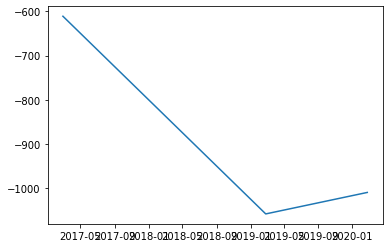

In [26]:
nonRsu = transactions[someCik]['rsus'] == False
plt.plot(transactions[someCik][nonRsu]['dates'], transactions[someCik][nonRsu]['amounts'])
plt.show()